# Info

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

from astropy import constants as cst
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import brentq

import pitszi
from pitszi import physics_main
import minot

# Define a cluster object and get the fluctuations properties

In [2]:
Tgas = 10*u.keV

cluster = pitszi.Model(redshift=0.5, M500=5e14*u.Msun)
cluster.set_pressure_profile_universal_param('A10UPP')
cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                      'Norm': 0.5, 
                                      'slope': -11/3.0,
                                      'Linj': 500*u.kpc,
                                      'Ldis': 1*u.kpc}

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Model                            
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.
Setting gNFW Arnaud et al. (2010) UPP.
Setting model_pressure_fluctuation value
Fixing: R500 if involved


In [3]:
k, pk = cluster.get_pressure_fluctuation_spectrum()
kpeak, pkpeak = cluster.get_pressure_fluctuation_spectrum(1/cluster.model_pressure_fluctuation['Linj'])

Amax  = np.amax(np.sqrt(4*np.pi*k**3 * pk).to_value(''))
Apeak = np.amax(np.sqrt(4*np.pi*kpeak**3 * pkpeak).to_value(''))

print('Norm sigma: ', cluster.model_pressure_fluctuation['Norm'])
print('Amax: ', Amax)
print('Apeak: ', Apeak)

Norm sigma:  0.5
Amax:  0.30823885308594323
Apeak:  0.2652437760984568


# Physical processes

In [4]:
# Computing Mach number with simple scaling
M3d_M20  = physics_main.sigma_to_M3d_M20(cluster.model_pressure_fluctuation['Norm'])
M3d_G13  = physics_main.Apeak_to_M3d_G13(Apeak, Linj=cluster.model_pressure_fluctuation['Linj'], alpha=0.25)
M3d_Z23  = physics_main.sigma_to_M3d_Z23(cluster.model_pressure_fluctuation['Norm'], state='in-between', ell=True, ret_err=True)
M3d_G13, M3d_Z23, M3d_M20

(0.6365850626362962,
 (0.6404152898455527, 0.21347176328185094),
 0.9050755487869557)

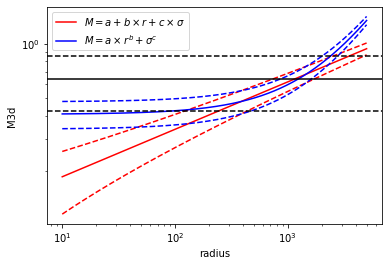

In [5]:
# Account for the radial dependence
state = 'in-between'
radius = np.logspace(1,np.log10(5000), 1000)*u.kpc
M3dr_Z23_s = physics_main.sigma_rad_to_M3d_Z23(cluster.model_pressure_fluctuation['Norm'], 
                                             (radius/cluster.R500).to_value(''),
                                             state=state, case='sum', ret_err=True)
M3dr_Z23_p = physics_main.sigma_rad_to_M3d_Z23(cluster.model_pressure_fluctuation['Norm'], 
                                             (radius/cluster.R500).to_value(''),
                                             state=state, case='prod', ret_err=True)

M3d_Z23 = physics_main.sigma_to_M3d_Z23(cluster.model_pressure_fluctuation['Norm'], state=state, ell=True, ret_err=True)

plt.plot(radius.value, M3dr_Z23_p[0], color='r', label=r'$M = a + b \times r + c \times \sigma$')
plt.plot(radius.value, M3dr_Z23_p[0]+M3dr_Z23_p[1], color='r', ls='--')
plt.plot(radius.value, M3dr_Z23_p[0]-M3dr_Z23_p[1], color='r', ls='--')
plt.plot(radius.value, M3dr_Z23_s[0], color='b', label=r'$M = a \times r^b + \sigma^c$')
plt.plot(radius.value, M3dr_Z23_s[0]+M3dr_Z23_s[1], color='b', ls='--')
plt.plot(radius.value, M3dr_Z23_s[0]-M3dr_Z23_s[1], color='b', ls='--')
plt.axhline(M3d_Z23[0], color='k')
plt.axhline(M3d_Z23[0]+M3d_Z23[1], color='k', ls='--')
plt.axhline(M3d_Z23[0]-M3d_Z23[1], color='k', ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('M3d')
plt.xlabel('radius')
plt.legend()

G13:  1029.8458078085482 km / s
Z23:  [1036.04221999  345.34740666] km / s


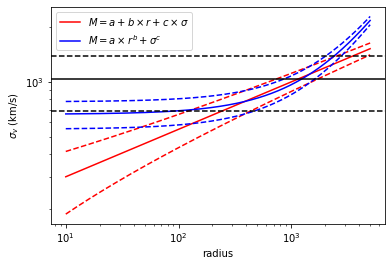

In [6]:
# Convert to velocity dispersion
cs = physics_main.sound_speed(Tgas)
sigmaV_G13 = cs*M3d_G13
sigmaV_Z23 = cs*M3d_Z23
print('G13: ', sigmaV_G13.to('km/s'))
print('Z23: ', sigmaV_Z23.to('km/s'))

plt.plot(radius.value, cs*M3dr_Z23_p[0], color='r', label=r'$M = a + b \times r + c \times \sigma$')
plt.plot(radius.value, cs*M3dr_Z23_p[0]+cs*M3dr_Z23_p[1], color='r', ls='--')
plt.plot(radius.value, cs*M3dr_Z23_p[0]-cs*M3dr_Z23_p[1], color='r', ls='--')
plt.plot(radius.value, cs*M3dr_Z23_s[0], color='b', label=r'$M = a \times r^b + \sigma^c$')
plt.plot(radius.value, cs*M3dr_Z23_s[0]+cs*M3dr_Z23_s[1], color='b', ls='--')
plt.plot(radius.value, cs*M3dr_Z23_s[0]-cs*M3dr_Z23_s[1], color='b', ls='--')
plt.axhline(cs.to_value('km/s')*M3d_Z23[0], color='k')
plt.axhline(cs.to_value('km/s')*M3d_Z23[0]+cs.to_value('km/s')*M3d_Z23[1], color='k', ls='--')
plt.axhline(cs.to_value('km/s')*M3d_Z23[0]-cs.to_value('km/s')*M3d_Z23[1], color='k', ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\sigma_v$ (km/s)')
plt.xlabel('radius')
plt.legend()

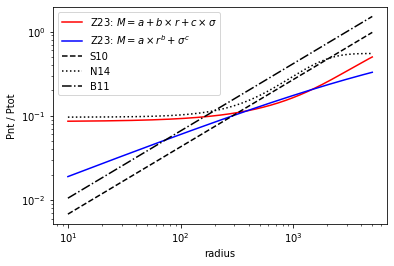

In [9]:
# Convert to P_NT / P_tot
Pratio_S10 = physics_main.pnt_over_ptot_r_S10(radius, cluster.R500, 1.5)
Pratio_B11 = physics_main.pnt_over_ptot_r_B11(radius, cluster.R500, 1.5)
Pratio_N14 = physics_main.pnt_over_ptot_r_N14(radius, cluster.R500, 1.5)

Pratio_Z23_s = physics_main.Eturb_over_Etherm(M3dr_Z23_s[0])
Pratio_Z23_p = physics_main.Eturb_over_Etherm(M3dr_Z23_p[0])

plt.plot(radius.value, 1/(1+1/Pratio_Z23_s), color='r', label=r'Z23: $M = a + b \times r + c \times \sigma$')
plt.plot(radius.value, 1/(1+1/Pratio_Z23_p), color='b', label=r'Z23: $M = a \times r^b + \sigma^c$')
plt.plot(radius.value, Pratio_S10, color='k', label=r'S10', ls='--')
plt.plot(radius.value, Pratio_N14, color='k', label=r'N14', ls=':')
plt.plot(radius.value, Pratio_B11, color='k', label=r'B11', ls='-.')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'Pnt / Ptot')
plt.xlabel('radius')
plt.legend()

In [ ]:
print('G13: ', physics_main.Eturb_over_Etherm(M3d_G13))
print('Z23: ', physics_main.Eturb_over_Etherm(M3d_Z23[0]))

# Testing lognormal rms for Zhuravleva+23 results

In [8]:
# Standard deviation in 3d given the sigma of the lognormal function
def sigln_to_sig3d(s):
    return ((np.exp(s**2) - 1)*np.exp(s**2))**0.5

def sig3d_to_sigln(s):
    sigln = np.linspace(0,10, 100000)
    sig3d = sigln_to_sig3d(sigln)
    itpl = interp1d(sig3d, sigln)
    return itpl(s)

def sig3d_to_sigln_bis(s):
    return np.sqrt(np.log((1+np.sqrt(1+4*s**2))/2))

In [9]:
sigma_ln = 0.3
delta_xi_over_xi = np.random.lognormal(0, sigma_ln, 1000000)
delta_xi_over_xi

array([1.06858296, 0.8548231 , 0.77226189, ..., 0.98387134, 1.35125117,
       1.12776192])

In [10]:
perc = np.percentile(delta_xi_over_xi, [12, 88])
sigma3D = ((np.exp(sigma_ln**2) - 1)*np.exp(sigma_ln**2))**0.5
perc, sigma3D

(array([0.70270185, 1.42303789]), 0.3210032389503257)

In [11]:
W = np.log10(perc[1]/perc[0])
W/sigma_ln, np.std(np.log(delta_xi_over_xi)), np.std(delta_xi_over_xi)/sigma3D

(1.0214845609829752, 0.30005666584516466, 1.0001075664252244)

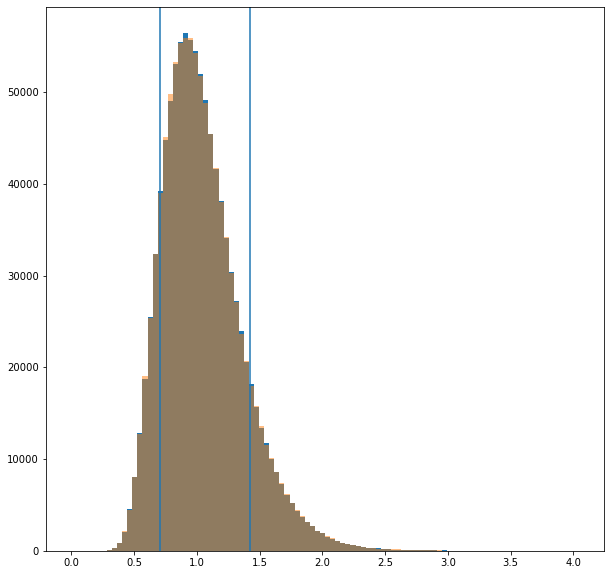

In [12]:
plt.figure(figsize=(10,10))
X = np.random.lognormal(0,sigma_ln,1000000)
plt.hist(X, bins=100, range=[0,np.amax(X)])
Y = np.exp(np.random.normal(0,sigma_ln,1000000))
plt.hist(Y, bins=100, alpha=0.5, range=[0,np.amax(X)])
plt.axvline(perc[0])
plt.axvline(perc[1])
#plt.yscale('log')
#plt.xscale('log')

Text(0, 0.5, 'sigma (\\int PK)^0.5')

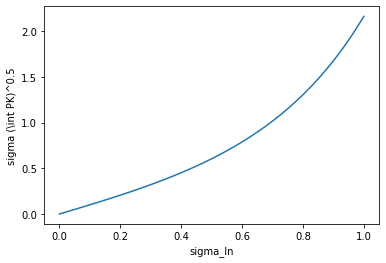

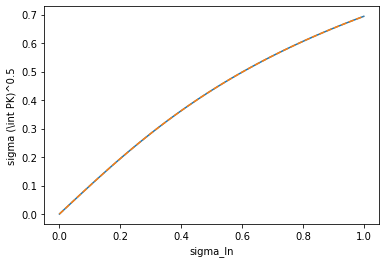

In [14]:
sigln = np.linspace(0,1,100)
plt.figure(0)
plt.plot(sigln, sigln_to_sig3d(sigln))
plt.xlabel('sigma_ln')
plt.ylabel('sigma (\int PK)^0.5')

plt.figure(1)
sig3d = np.linspace(0,1,100)
plt.plot(sigln, sig3d_to_sigln(sig3d))
plt.plot(sigln, sig3d_to_sigln_bis(sig3d), ls='--')
plt.xlabel('sigma_ln')
plt.ylabel('sigma (\int PK)^0.5')